In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [17]:
#Copiado Keras
model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

#Carregar modelo
model = load_model('./trained_model_60epochs')

In [27]:
#Carregar imagem
image_size = (180, 180)
#img_path = "../images/Massas/nao-prontas/prcsd_set000554.png"
img_path = "../images//Massas/prontas/prcsd_set001408.png"

img_array = get_img_array(img_path, image_size)

preds = model.predict(img_array)
preds

1/1 [==============================] - 0s 39ms/step


array([[0.9999559]], dtype=float32)

In [28]:
def extract_separable_conv_layer_names():
    base_name = "separable_conv2d"
    separable_conv_layers = []
    for layer in model.layers:
        if base_name in layer.name:
            separable_conv_layers.append(layer.name)
    return separable_conv_layers

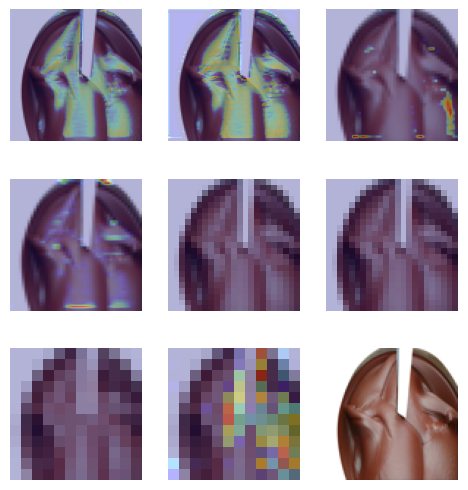

In [29]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Generate class activation heatmap
separable_conv_layer_names = extract_separable_conv_layer_names()

heatmaps = []
for layer_name in separable_conv_layer_names:
    heatmaps.append(make_gradcam_heatmap(img_array, model, layer_name))
    
img = keras.preprocessing.image.load_img(img_path)
img = img.resize((90, 90))

# Display heatmap
fig, axarr = plt.subplots(3, 3)

img = img.resize((90, 90))
axarr[0, 0].imshow(img)
axarr[0, 0].imshow(heatmaps[0], cmap='jet', alpha=0.3)
axarr[0, 0].axis('off')

axarr[0, 1].imshow(img)
axarr[0, 1].imshow(heatmaps[1], cmap='jet', alpha=0.3)
axarr[0, 1].axis('off')

axarr[2, 2].imshow(img)
axarr[2, 2].axis('off')

img = img.resize((45, 45))
axarr[0, 2].imshow(img)
axarr[0, 2].imshow(heatmaps[2], cmap='jet', alpha=0.3)
axarr[0, 2].axis('off')

axarr[1, 0].imshow(img)
axarr[1, 0].imshow(heatmaps[3], cmap='jet', alpha=0.3)
axarr[1, 0].axis('off')

img = img.resize((23, 23))
axarr[1, 1].imshow(img)
axarr[1, 1].imshow(heatmaps[4], cmap='jet', alpha=0.3)
axarr[1, 1].axis('off')

axarr[1, 2].imshow(img)
axarr[1, 2].imshow(heatmaps[5], cmap='jet', alpha=0.3)
axarr[1, 2].axis('off')

img = img.resize((12, 12))
axarr[2, 0].imshow(img)
axarr[2, 0].imshow(heatmaps[6], cmap='jet', alpha=0.3)
axarr[2, 0].axis('off')

axarr[2, 1].imshow(img)
axarr[2, 1].imshow(heatmaps[7], cmap='jet', alpha=0.3)
axarr[2, 1].axis('off')


plt.subplots_adjust(bottom=1, right=1.7, top=2, left=1)

#fig = plt.figure(figsize=(10., 10.))
#grid = ImageGrid(fig, 111, nrows_ncols=(1, 8), axes_pad=0)

#for ax, im in zip(grid, heatmaps):
#    ax.matshow(im)

plt.show()

In [ ]:
model.summary()